# Deep Learning -  MeteoNet RNN's

- Juan Sebastián Vargas

## Context

MeteoNet (https://meteonet.umr-cnrm.fr/) is a data set published by the French meteorological service METEO FRANCE for the community to propose analyzes and models using climate data.

Some of the data available on MeteoNet are the historical meteorological observations of sensors that measure temperature, humidity, pressure, wind in different stations located throughout the French territory. You can consult this link more about the data of meteorological observations (https://meteofrance.github.io/meteonet/english/data/ground-observations/)



### Imports

In [ ]:
pip install cartopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 66.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 123.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 6.9 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp39-cp39-linux_x86_64.whl size=11113634 sha256=c02ce57e49bf84413b36876a5f75dde3ed7e87a8ee8b264f09031a9218db87ca
  Stored in directory: /root/.cache/pip/wheels/74/b9/f5/2c94acd7cd21480e6cf63169144d7aac3e8d9cf638225ed578
Successfully built cartopy


In [ ]:
import pandas as pd
from google.colab import drive
import math
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras import activations
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error,mean_absolute_error
from tables import index
import seaborn as sns

### Mount Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### Util Fuctions

In [ ]:
def getBestNanStationProportion(stations_df):
  stations = stations_df["number_sta"].unique()
  smallestNullRatio=math.inf
  selectedStationId=0
  for station in stations:
    selectedStation =  stations_df.loc[(stations_df["number_sta"]==station)]
    totalNans = selectedStation.isna().sum().sum()
    ratio=totalNans/selectedStation.shape[0]*selectedStation.shape[1]
    #print(f"Station #{station}, has {totalNans} Null values , shape: {selectedStation.shape[0]}, Null ration: {ratio}")
    if(ratio<smallestNullRatio):
      smallestNullRatio=ratio
      selectedStationId=station
  return selectedStationId

In [ ]:
def  getLimitsAndMedian(attribute, n=1.5):

  # Cuartil 1
  q1 = attribute.quantile(0.25)

  # Cuartil 3
  q3 = attribute.quantile(0.75)

  med = attribute.median()

  # IQR
  iqr = q3-q1

  upper_bound = q3+(n*iqr)
  lower_bound = q1-(n*iqr)

  print("Q1: ",q1," Q3: ", q3," Median: ", med," IQR: ", iqr)
  return upper_bound, lower_bound, med

In [ ]:
def plot_temperature_evolution(selectedStationDf):
  plot_temp= selectedStationDf["t"]
  plot_temp.index=selectedStationDf["date"]
  plt.figure(figsize=(10,5))
  plt.ylabel('Temperature (K)')
  plt.title('Temperature evolution of the station '+str(selectedStatitonId))
  plot_temp.plot(subplots=True, color="orange")
  plt.show()

In [ ]:
def plot_precipitation_evolution(selectedStationDf):
  plot_precip= selectedStationDf["precip"]
  plot_precip.index=selectedStationDf["date"]
  plt.figure(figsize=(10,5))
  plt.ylabel('Precipitation (kg.m2)')
  plt.title('Precipitation evolution of the station '+str(selectedStatitonId))
  plot_precip.plot(subplots=True, color="blue")
  plt.show()

### Reading Data


#### One year data
This is useful if you don´t have enough RAM, so can do the forcasting base on just one year.

In [ ]:
# YEAR =2018
# year_data_path = f'/content/drive/MyDrive/RNN_Weather_data/NW{YEAR}.csv'
# cols = ['number_sta','lat','lon','date','height_sta','dd','ff','precip','hu','td','t','psl']

In [ ]:
#df= pd.read_csv(year_data_path,usecols = cols, parse_dates=['date'],infer_datetime_format=True)

#### Separated data
This is just in case you don´t have the complete data, instead run "merge data"

In [ ]:
data_2016_path = '/content/drive/MyDrive/RNN_Weather_data/NW2016.csv'
data_2017_path = '/content/drive/MyDrive/RNN_Weather_data/NW2017.csv'
data_2018_path = '/content/drive/MyDrive/RNN_Weather_data/NW2018.csv'

In [ ]:
cols = ['number_sta','lat','lon','date','height_sta','dd','ff','precip','hu','td','t','psl']    # columns we need in the array

# df = pd.concat([pd.read_csv(data_2017_path,usecols = cols, parse_dates=['date'],infer_datetime_format=True),
#                 pd.read_csv(data_2018_path,usecols = cols,parse_dates=['date'],infer_datetime_format=True)], axis=0)

df = pd.concat([pd.read_csv(data_2016_path,usecols = cols, parse_dates=['date'],infer_datetime_format=True),
                pd.read_csv(data_2017_path,usecols = cols, parse_dates=['date'],infer_datetime_format=True),
                pd.read_csv(data_2018_path,usecols = cols,parse_dates=['date'],infer_datetime_format=True)], axis=0)

In [ ]:
# file_path = '/content/drive/MyDrive/RNN_Weather_data/CompleteStationsData.csv'
# df.to_csv(file_path, index=False)

#### Merge data
Data that was merged from the three files, it contains all the data of all the stations in one file. (Make sure to have enough RAM >25GB)

In [ ]:
# file_path = '/content/drive/MyDrive/RNN_Weather_data/CompleteStationsData.csv'
# df=pd.read_csv(file_path)

### Exploring Data

In [ ]:
df.shape

(65826837, 12)

In [ ]:
df.head(5)

,number_sta,lat,lon,height_sta,date,dd,ff,precip,hu,td,t,psl
0,14066001,49.33,-0.43,2.0,2016-01-01,210.0,4.4,0.0,91.0,278.45,279.85,NaN
1,14126001,49.15,0.04,125.0,2016-01-01,NaN,NaN,0.0,99.0,278.35,278.45,NaN
2,14137001,49.18,-0.46,67.0,2016-01-01,220.0,0.6,0.0,92.0,276.45,277.65,102360.0
3,14216001,48.93,-0.15,155.0,2016-01-01,220.0,1.9,0.0,95.0,278.25,278.95,NaN
4,14296001,48.80,-1.03,339.0,2016-01-01,NaN,NaN,0.0,NaN,NaN,278.35,NaN


In [ ]:
#selectedStatitonId = getBestNanStationProportion(df)
selectedStatitonId = 53130008

In [ ]:
df.isna().sum().sum()

170412499

In [ ]:
df.isna().sum()

number_sta           0
lat                  0
lon                  0
height_sta           0
date                 0
dd            25862210
ff            25839526
precip         3778807
hu            26438641
td            26458088
t              9438123
psl           52597104
dtype: int64

In [ ]:
selected_station_df= df.loc[(df["number_sta"]==selectedStatitonId)]

In [ ]:
selected_station_df.shape

(261853, 12)

In [ ]:
selected_station_df.head(5)

,number_sta,lat,lon,height_sta,date,dd,ff,precip,hu,td,t,psl
150,53130008,48.03,-0.75,100.0,2016-01-01 00:00:00,170.0,1.9,0.0,96.0,279.55,280.15,102360.0
398,53130008,48.03,-0.75,100.0,2016-01-01 00:06:00,160.0,1.8,0.0,96.0,279.35,279.95,102380.0
647,53130008,48.03,-0.75,100.0,2016-01-01 00:12:00,160.0,1.9,0.0,96.0,279.35,279.95,102360.0
895,53130008,48.03,-0.75,100.0,2016-01-01 00:18:00,160.0,1.7,0.0,97.0,279.55,279.95,102360.0
1144,53130008,48.03,-0.75,100.0,2016-01-01 00:24:00,170.0,1.5,0.0,97.0,279.65,280.05,102350.0


In [ ]:
selected_station_df.isna().sum()

number_sta     0
lat            0
lon            0
height_sta     0
date           0
dd            23
ff            23
precip        36
hu            11
td            12
t             12
psl           12
dtype: int64

In [ ]:
selected_station_df.dtypes

number_sta             int64
lat                  float64
lon                  float64
height_sta           float64
date          datetime64[ns]
dd                   float64
ff                   float64
precip               float64
hu                   float64
td                   float64
t                    float64
psl                  float64
dtype: object

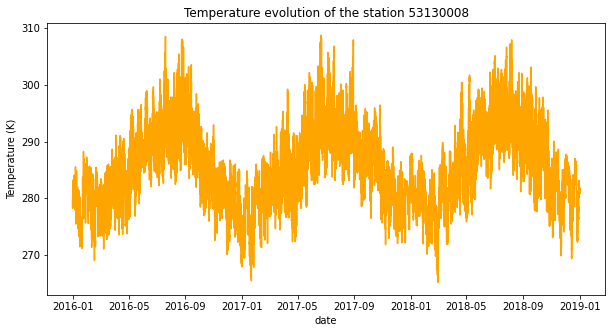

In [ ]:
plot_temperature_evolution(selected_station_df)

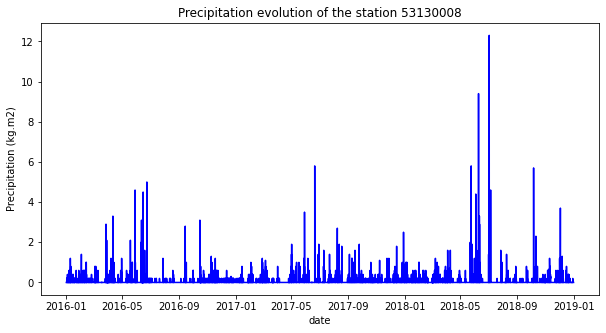

In [ ]:
plot_precipitation_evolution(selected_station_df)

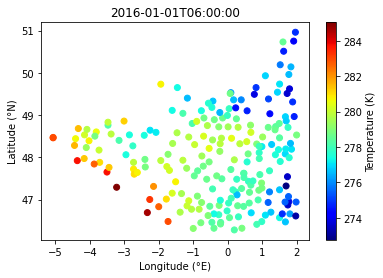

In [ ]:
date = '2016-01-01T06:00:00'
d_sub = df[df['date'] == date]
plt.figure()
plt.scatter(d_sub['lon'], d_sub['lat'], c=d_sub['t'], cmap='jet')
plt.xlabel('Longitude (°E)')
plt.ylabel('Latitude (°N)')
plt.title(date)
plt.colorbar().set_label('Temperature (K)')
plt.show()

In [ ]:
def plot_allstations_temperature_registers(complete_df):
  # Coordinates of studied area boundaries (in °N and °E)
  lllat = 46.25  #lower left latitude
  urlat = 51.896  #upper right latitude
  lllon = -5.842  #lower left longitude
  urlon = 2  #upper right longitude
  extent = [lllon, urlon, lllat, urlat]
  dates = complete_df["date"].unique()[:5]
  #['2016-01-01 00:00:00','2016-01-01 00:06:00','2016-01-01 00:12:00','2016-01-01 00:18:00']
  for date in dates:
    clear_output(wait=True)
    d_sub = complete_df[complete_df['date'] == date]
    fig = plt.figure(figsize=(9,5))

    # Select projection
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Plot the data
    plt.scatter(d_sub['lon'], d_sub['lat'], c=d_sub['t'], cmap='jet')
    plt.colorbar().set_label('Temperature (K)')
    plt.title(date)

    ax.coastlines(resolution='50m', linewidth=1)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'))

    # Adjust the plot to the area we defined
    #/!\# this line causes a bug of the kaggle notebook and clears all the memory. That is why this line is commented and so
    # the plot is not completely adjusted to the data
    #ax.set_extent(extent)

    plt.show()

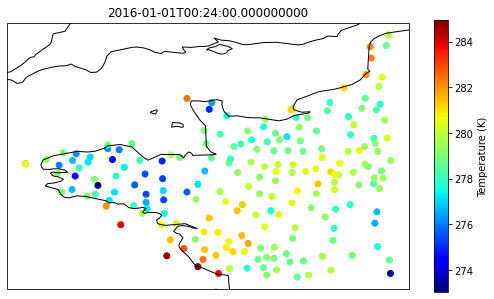

In [ ]:
plot_allstations_temperature_registers(df)

### Cleaning and Preparing Data

In [ ]:
selected_station_df = selected_station_df.fillna(df.median())

<ipython-input-29-8fded465433e>:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  selected_station_df = selected_station_df.fillna(df.median())


In [ ]:
selected_station_df.isna().sum()

number_sta    0
lat           0
lon           0
height_sta    0
date          0
dd            0
ff            0
precip        0
hu            0
td            0
t             0
psl           0
dtype: int64

In [ ]:
selected_station_df.head(5)

,number_sta,lat,lon,height_sta,date,dd,ff,precip,hu,td,t,psl
150,53130008,48.03,-0.75,100.0,2016-01-01 00:00:00,170.0,1.9,0.0,96.0,279.55,280.15,102360.0
398,53130008,48.03,-0.75,100.0,2016-01-01 00:06:00,160.0,1.8,0.0,96.0,279.35,279.95,102380.0
647,53130008,48.03,-0.75,100.0,2016-01-01 00:12:00,160.0,1.9,0.0,96.0,279.35,279.95,102360.0
895,53130008,48.03,-0.75,100.0,2016-01-01 00:18:00,160.0,1.7,0.0,97.0,279.55,279.95,102360.0
1144,53130008,48.03,-0.75,100.0,2016-01-01 00:24:00,170.0,1.5,0.0,97.0,279.65,280.05,102350.0


In [ ]:
selected_station_df.tail(5)

,number_sta,lat,lon,height_sta,date,dd,ff,precip,hu,td,t,psl
22033431,53130008,48.031,-0.747,100.0,2018-12-31 23:30:00,40.0,2.0,0.0,86.0,278.65,280.85,103720.0
22033692,53130008,48.031,-0.747,100.0,2018-12-31 23:36:00,20.0,2.2,0.0,84.0,278.45,280.95,103720.0
22033952,53130008,48.031,-0.747,100.0,2018-12-31 23:42:00,20.0,2.5,0.0,84.0,278.55,281.05,103720.0
22034213,53130008,48.031,-0.747,100.0,2018-12-31 23:48:00,20.0,2.5,0.0,84.0,278.55,281.05,103720.0
22034473,53130008,48.031,-0.747,100.0,2018-12-31 23:54:00,360.0,1.7,0.0,86.0,278.75,280.95,103710.0


In [ ]:
selected_station_df.dtypes

number_sta             int64
lat                  float64
lon                  float64
height_sta           float64
date          datetime64[ns]
dd                   float64
ff                   float64
precip               float64
hu                   float64
td                   float64
t                    float64
psl                  float64
dtype: object

array([[<Axes: title={'center': 'number_sta'}>,
        <Axes: title={'center': 'lat'}>, <Axes: title={'center': 'lon'}>],
       [<Axes: title={'center': 'height_sta'}>,
        <Axes: title={'center': 'date'}>, <Axes: title={'center': 'dd'}>],
       [<Axes: title={'center': 'ff'}>,
        <Axes: title={'center': 'precip'}>,
        <Axes: title={'center': 'hu'}>],
       [<Axes: title={'center': 'td'}>, <Axes: title={'center': 't'}>,
        <Axes: title={'center': 'psl'}>]], dtype=object)

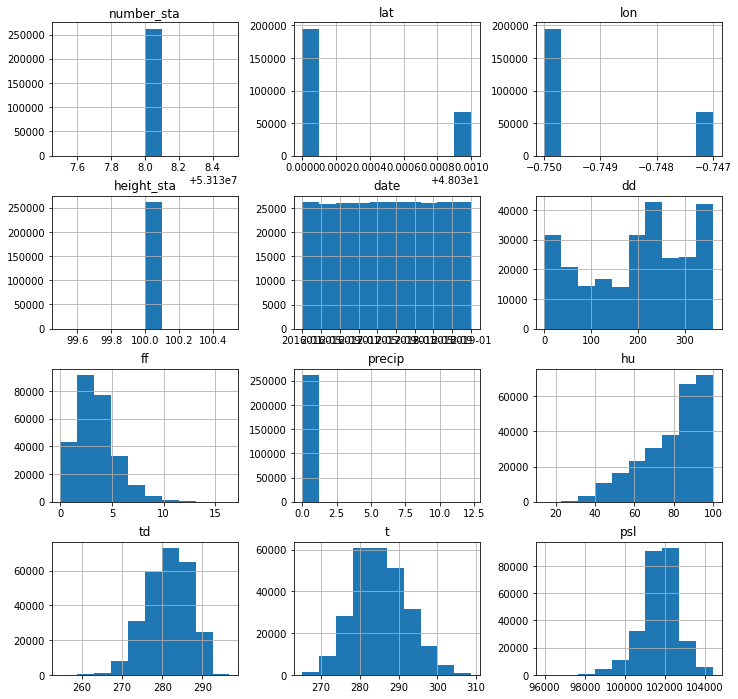

In [ ]:
selected_station_df.hist(figsize=(12,12))

In [ ]:
selected_station_df.describe()

,number_sta,lat,lon,height_sta,dd,ff,precip,hu,td,t,psl
count,261853.0,261853.000000,261853.000000,261853.0,261853.000000,261853.000000,261853.000000,261853.000000,261853.000000,261853.000000,261853.000000
mean,53130008.0,48.030256,-0.749231,100.0,197.936018,3.433916,0.008273,79.402378,281.369758,285.255006,101744.391128
std,0.0,0.000437,0.001310,0.0,110.115551,1.898797,0.080305,16.031799,5.355395,6.871485,915.183119
min,53130008.0,48.030000,-0.750000,100.0,0.000000,0.000000,0.000000,14.000000,254.650000,265.150000,95970.000000
25%,53130008.0,48.030000,-0.750000,100.0,100.000000,2.100000,0.000000,69.000000,277.750000,280.350000,101260.000000
50%,53130008.0,48.030000,-0.750000,100.0,220.000000,3.200000,0.000000,84.000000,281.650000,284.750000,101820.000000
75%,53130008.0,48.031000,-0.747000,100.0,290.000000,4.500000,0.000000,92.000000,285.550000,289.950000,102320.000000
max,53130008.0,48.031000,-0.747000,100.0,360.000000,16.400000,12.300000,100.000000,296.750000,308.750000,104400.000000


In [ ]:
corr = selected_station_df.corr()
corr.style.background_gradient(cmap='coolwarm')

/usr/local/lib/python3.9/dist-packages/pandas/io/formats/style.py:3555: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.9/dist-packages/pandas/io/formats/style.py:3556: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,number_sta,lat,lon,height_sta,dd,ff,precip,hu,td,t,psl
number_sta,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
lat,nan,1.000000,1.000000,nan,-0.035709,-0.037678,0.005675,-0.085707,0.206530,0.213093,-0.020470
lon,nan,1.000000,1.000000,nan,-0.035709,-0.037678,0.005675,-0.085707,0.206530,0.213093,-0.020470
height_sta,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
dd,nan,-0.035709,-0.035709,nan,1.000000,0.068208,0.009017,0.076338,0.125898,0.057849,-0.023845
ff,nan,-0.037678,-0.037678,nan,0.068208,1.000000,0.080789,-0.200962,-0.082112,0.025416,-0.353412
precip,nan,0.005675,0.005675,nan,0.009017,0.080789,1.000000,0.079090,0.039817,-0.007019,-0.100449
hu,nan,-0.085707,-0.085707,nan,0.076338,-0.200962,0.079090,1.000000,-0.083497,-0.588671,-0.030204
td,nan,0.206530,0.206530,nan,0.125898,-0.082112,0.039817,-0.083497,1.000000,0.850070,-0.102713
t,nan,0.213093,0.213093,nan,0.057849,0.025416,-0.007019,-0.588671,0.850070,1.000000,-0.060999


In [ ]:
#multi_data = selected_station_df[["dd","ff","hu","td","psl","t"]]
multi_data = selected_station_df[["td","t"]]
multi_data.index = selected_station_df['date']
#multi_data.drop(columns=["number_sta","date","lat","lon","height_sta","precip"],inplace=True)

array([[<Axes: title={'center': 'td'}>, <Axes: title={'center': 't'}>]],
      dtype=object)

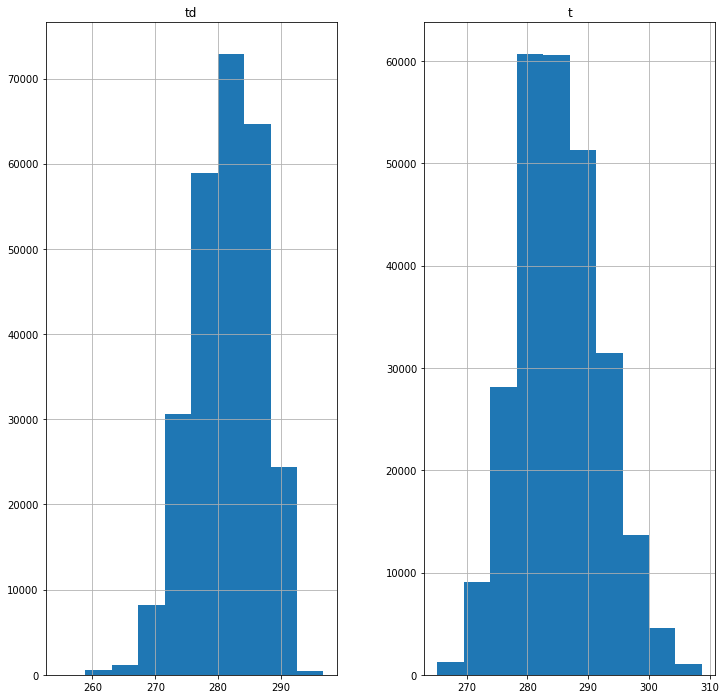

In [ ]:
multi_data.hist(figsize=(12,12))

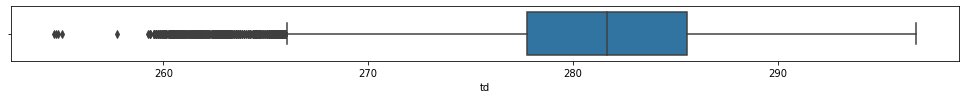

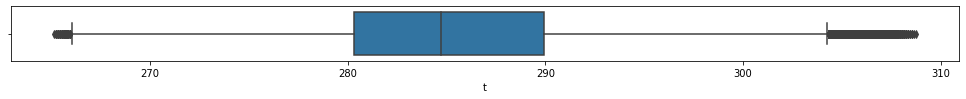

In [ ]:
df_numeric=multi_data.select_dtypes(exclude=['object','datetime'])
for column in df_numeric:
    plt.figure(figsize=(17,1))
    sns.boxplot(data=df_numeric, x=column)

In [ ]:
for c in multi_data.columns[:-1]:
  upper_bound, lower_bound,median = getLimitsAndMedian(multi_data[c])
  multi_data.loc[(multi_data[c] > upper_bound) | (multi_data[c] < lower_bound),c]=median

Q1:  277.75  Q3:  285.55  Median:  281.65  IQR:  7.800000000000011


<ipython-input-40-20bc4d263b53>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_data.loc[(multi_data[c] > upper_bound) | (multi_data[c] < lower_bound),c]=median


In [ ]:
multi_data.head(5)

,td,t
date,,
2016-01-01 00:00:00,279.55,280.15
2016-01-01 00:06:00,279.35,279.95
2016-01-01 00:12:00,279.35,279.95
2016-01-01 00:18:00,279.55,279.95
2016-01-01 00:24:00,279.65,280.05


In [ ]:
for c in multi_data.columns[:]:
  print("*********",c,"*********")
  print(multi_data[c].value_counts())
  print("*******************")
  print("\n")

********* td *********
281.65    2775
280.95    2064
280.85    1929
280.75    1893
285.45    1883
          ... 
295.05       1
295.25       1
296.25       1
296.75       1
294.95       1
Name: td, Length: 304, dtype: int64
*******************


********* t *********
281.65    1778
282.75    1776
281.75    1726
281.05    1702
284.15    1702
          ... 
308.55       3
308.45       2
308.65       1
308.75       1
265.15       1
Name: t, Length: 437, dtype: int64
*******************




In [ ]:
# coeff_train = 0.8  #proportion of the dataset in the training set
# TRAIN_SPLIT = round(uni_data.shape[0]*coeff_train)
# print(TRAIN_SPLIT)

# coeff_validation_boundary = coeff_train+0.1 ## This represents the boundary of the validation data which will be the next 10% of the data after the train set, and the last 10 % of the data will be the test
# VALIDATION_SPLIT_BOUNDARY = round(uni_data.shape[0]*coeff_validation_boundary)
# print(VALIDATION_SPLIT_BOUNDARY)

In [ ]:
coeff_train = 0.7  #proportion of the dataset in the training set
TRAIN_SPLIT = round(multi_data.shape[0]*coeff_train)
print(TRAIN_SPLIT)

coeff_validation_boundary = coeff_train+0.1 ## This represents the boundary of the validation data which will be the next 10% of the data after the train set, and the last 10 % of the data will be the test
VALIDATION_SPLIT_BOUNDARY = round(multi_data.shape[0]*coeff_validation_boundary)
print(VALIDATION_SPLIT_BOUNDARY)

183297
209482


In [ ]:
def multivariate_data(x_data, start_index, end_index,input_size ,target_size,split=1):
    data = []
    labels = []
    start_index = start_index + input_size
    if end_index is None:
        end_index = len(x_data) - target_size

    for i in range(start_index, end_index):
        data.append(x_data[(i-input_size):i])
        #labels.append(np.max(x_data[i:i+target_size]))
        all_labels=list(x_data[i+1:i+target_size+1]["t"])
        all_labels=np.array_split(all_labels,split)
        max_values = [np.max(l) for l in all_labels]
        labels_result = np.array(max_values)
        labels.append(labels_result)
    return np.array(data), np.array(labels)

In [ ]:
# time_horizon= 3*24*10 ## every day

# univariate_past_history = time_horizon
# univariate_future_target = time_horizon

# x_train,y_train = univariate_data(uni_data, 0,TRAIN_SPLIT,univariate_past_history,univariate_future_target)
# x_val,y_val = univariate_data(uni_data, TRAIN_SPLIT, VALIDATION_SPLIT_BOUNDARY,univariate_past_history,univariate_future_target)
# x_test,y_test = univariate_data(uni_data, VALIDATION_SPLIT_BOUNDARY, None,univariate_past_history,univariate_future_target)

In [ ]:
BASE_TIME_HORIZON_DAYS=2 ## 7 days or 1 week
time_horizon= BASE_TIME_HORIZON_DAYS*24*10

multivariate_past_history = time_horizon
multivariate_future_target = time_horizon

x_train,y_train = multivariate_data(multi_data, 0,TRAIN_SPLIT,multivariate_past_history,multivariate_future_target,split=BASE_TIME_HORIZON_DAYS)
x_val,y_val = multivariate_data(multi_data, TRAIN_SPLIT, VALIDATION_SPLIT_BOUNDARY,multivariate_past_history,multivariate_future_target,split=BASE_TIME_HORIZON_DAYS)
x_test,y_test = multivariate_data(multi_data, VALIDATION_SPLIT_BOUNDARY, None,multivariate_past_history,multivariate_future_target,split=BASE_TIME_HORIZON_DAYS)

In [ ]:
x_train[0]

array([[279.55, 280.15],
       [279.35, 279.95],
       [279.35, 279.95],
       [279.55, 279.95],
       [279.65, 280.05],
       [279.65, 280.05],
       [279.55, 279.95],
       [279.45, 279.85],
       [279.45, 279.85],
       [279.15, 279.55],
       [279.25, 279.65],
       [279.35, 279.75],
       [279.45, 279.85],
       [279.45, 279.85],
       [279.25, 279.65],
       [279.35, 279.75],
       [279.15, 279.55],
       [278.05, 278.65],
       [278.45, 278.85],
       [278.25, 278.65],
       [278.45, 278.85],
       [278.55, 278.95],
       [278.45, 278.85],
       [278.25, 278.65],
       [278.35, 278.75],
       [278.35, 278.75],
       [277.85, 278.25],
       [278.15, 278.45],
       [278.65, 278.95],
       [278.85, 279.15],
       [278.95, 279.25],
       [278.85, 279.15],
       [278.45, 278.85],
       [278.25, 278.65],
       [278.35, 278.65],
       [278.35, 278.65],
       [278.35, 278.65],
       [278.55, 278.85],
       [278.55, 278.85],
       [278.65, 278.95],


In [ ]:
y_train[0]

array([283.55, 284.05])

In [ ]:
print(x_train.shape)
print(y_train.shape)

(182817, 480, 2)
(182817, 2)


In [ ]:
print(x_val.shape)
print(y_val.shape)

(25705, 480, 2)
(25705, 2)


In [ ]:
print(x_test.shape)
print(y_test.shape)

(51411, 480, 2)
(51411, 2)


In [ ]:
x_train_mean = np.mean(x_train, axis=(0, 1))
x_train_std = np.std(x_train, axis=(0, 1))

#Let's standardize the data:
x_train_scaled = (x_train-x_train_mean)/x_train_std
x_val_scaled = (x_val-x_train_mean)/x_train_std
x_test_scaled = (x_test-x_train_mean)/x_train_std



In [ ]:
def plot_train_sequence_sample(sequence, label, SEQ_INDEX):
  sequence_size=len(sequence)
  plt.title('Example of sequence #'+str(SEQ_INDEX))
  plt.xlabel('Time-Step')
  plt.ylabel('temperature')
  plt.plot(np.arange(0,sequence_size), sequence, label="Previous Sequence of temp's")
  plt.plot(np.arange(sequence_size+1,(sequence_size*2)+1),label,color="red", label="Next temp to predict")
  plt.legend(loc="upper left")
  plt.show()

In [ ]:
# SEQ_INDEX=0
# plot_train_sequence_sample(x_train[SEQ_INDEX], y_train[SEQ_INDEX],SEQ_INDEX)

In [ ]:
train_plt=np.concatenate(y_train, axis=0)
val_plt=np.concatenate(y_val, axis=0)
test_plt=np.concatenate(y_test, axis=0)

In [ ]:
train_len=len(train_plt)
val_len=len(val_plt)+train_len
test_len=len(test_plt)+val_len

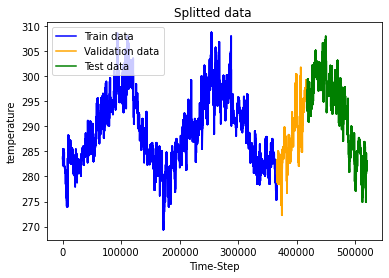

In [ ]:
plt.title('Splitted data ')
plt.xlabel('Time-Step')
plt.ylabel('temperature')
plt.plot(np.arange(0,train_len),train_plt, label="Train data", color="blue")
plt.plot(np.arange(train_len,val_len),val_plt, label="Validation data", color="orange")
plt.plot(np.arange(val_len,test_len),test_plt, label="Test data", color="green")
plt.legend(loc="upper left")
plt.show()

### Training

In [ ]:
tf.random.set_seed(42)

In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_scaled, y_train))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_scaled, y_val))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()


test_univariate = tf.data.Dataset.from_tensor_slices((x_test_scaled, y_test))
test_univariate = test_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
for input_example, target_example in train_univariate.take(1):
  print("Input :",input_example)
  print("Target:",target_example)

Input : tf.Tensor(
[[[ 0.10367989 -0.2314189 ]
  [ 0.10367989 -0.2314189 ]
  [ 0.10367989 -0.2314189 ]
  ...
  [-1.24332498 -1.24812901]
  [-1.26256791 -1.26308063]
  [-1.26256791 -1.26308063]]

 [[-1.55121181 -1.69667759]
  [-1.57045474 -1.71162921]
  [-1.60894059 -1.71162921]
  ...
  [-0.08874938 -0.20151567]
  [-0.12723523 -0.15666081]
  [-0.1079923  -0.17161243]]

 [[ 0.1806516  -0.36598348]
  [ 0.16140867 -0.3809351 ]
  [ 0.12292282 -0.41083833]
  ...
  [-0.18496401 -0.44074157]
  [-0.16572108 -0.44074157]
  [-0.16572108 -0.44074157]]

 ...

 [[-0.16572108 -0.35103186]
  [-0.16572108 -0.36598348]
  [-0.18496401 -0.3809351 ]
  ...
  [ 0.14216575  0.03771024]
  [ 0.14216575  0.03771024]
  [ 0.14216575  0.03771024]]

 [[-1.64742645 -1.69667759]
  [-1.6859123  -1.71162921]
  [-1.66666937 -1.71162921]
  ...
  [-0.83922352 -1.09861282]
  [-0.83922352 -1.09861282]
  [-0.83922352 -1.09861282]]

 [[-0.18496401 -0.3809351 ]
  [-0.14647816 -0.3809351 ]
  [-0.1079923  -0.3809351 ]
  ...
  [ 0

In [ ]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8,input_shape=(time_horizon, multi_data.shape[1])),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(4, activation=activations.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(BASE_TIME_HORIZON_DAYS)
])

simple_lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0012), loss='mae')

In [ ]:
simple_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 352       
                                                                 
 dense (Dense)               (None, 4)                 36        
                                                                 
 batch_normalization (BatchN  (None, 4)                16        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 2)                 10        
                                                                 
Total params: 414
Trainable params: 406
Non-trainable params: 8
_________________________________________________________________


In [ ]:
for x,y in test_univariate.take(1):
    print(x.shape)
    pr= simple_lstm_model.predict(x)
    print(pr)
    print(pr.shape)

(256, 480, 2)
8/8 [==============================] - 4s 9ms/step
[[-7.16269135e-01  2.10090893e-05]
 [-7.21013844e-01  1.79724605e-03]
 [-7.22324729e-01  1.20205060e-03]
 [-7.20996380e-01 -1.57600560e-03]
 [-7.18965530e-01 -6.16591237e-03]
 [-7.17330277e-01 -5.24702482e-03]
 [-7.17261970e-01 -6.77394588e-03]
 [-7.16641724e-01 -6.43417705e-03]
 [-7.16128111e-01 -8.08130670e-03]
 [-7.15275526e-01 -8.53369664e-03]
 [-7.15131819e-01 -9.14480072e-03]
 [-7.15278149e-01 -7.54291890e-03]
 [-7.16177166e-01 -6.94843382e-03]
 [-7.17053175e-01 -5.77355688e-03]
 [-7.17845917e-01 -5.29196067e-03]
 [-7.18413651e-01 -4.36911080e-03]
 [-7.19587207e-01 -3.20422743e-03]
 [-7.20932066e-01 -1.83644204e-03]
 [-7.21595883e-01 -3.42335040e-03]
 [-7.21894264e-01 -1.80036307e-03]
 [-7.23160923e-01 -9.64769744e-04]
 [-7.24654615e-01  6.98581920e-04]
 [-7.26275444e-01  2.44576926e-03]
 [-7.27580369e-01  3.20470659e-03]
 [-7.28743970e-01  4.45887493e-03]
 [-7.29633868e-01  4.33437387e-03]
 [-7.30266988e-01  5.4093

In [ ]:
STEPS_PER_EPOCH = x_train.shape[0]//BATCH_SIZE
VAL_STEPS = x_val.shape[0]//BATCH_SIZE
print(STEPS_PER_EPOCH)
print(VAL_STEPS)

714
100


In [ ]:
callback_early = EarlyStopping(monitor='val_loss', mode='min', patience=10)

#callback_checkpoint= ModelCheckpoint(filepath='/tmp/checkpoints',monitor='val_loss', mode='min',save_best_only=True)

In [ ]:
EPOCHS=120
history = simple_lstm_model.fit(train_univariate, epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,callbacks=[callback_early], validation_data=val_univariate, validation_steps = VAL_STEPS)
#history = simple_lstm_model.fit(train_univariate, epochs=EPOCHS)

Epoch 1/120
714/714 [==============================] - 15s 16ms/step - loss: 286.2926 - val_loss: 277.8630
Epoch 2/120
714/714 [==============================] - 11s 16ms/step - loss: 270.7020 - val_loss: 253.6177
Epoch 3/120
714/714 [==============================] - 11s 15ms/step - loss: 243.1583 - val_loss: 219.1819
Epoch 4/120
714/714 [==============================] - 11s 16ms/step - loss: 205.7989 - val_loss: 179.0989
Epoch 5/120
714/714 [==============================] - 11s 15ms/step - loss: 159.9658 - val_loss: 127.9853
Epoch 6/120
714/714 [==============================] - 11s 16ms/step - loss: 106.4608 - val_loss: 65.7052
Epoch 7/120
714/714 [==============================] - 11s 15ms/step - loss: 45.7800 - val_loss: 4.3203
Epoch 8/120
714/714 [==============================] - 11s 15ms/step - loss: 4.4085 - val_loss: 3.8561
Epoch 9/120
714/714 [==============================] - 11s 15ms/step - loss: 3.9592 - val_loss: 4.6959
Epoch 10/120
714/714 [===========================

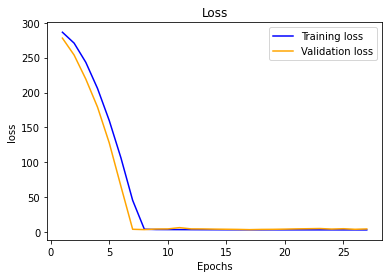

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
prediction= simple_lstm_model.predict(x_test_scaled)
print(prediction)
print(prediction.shape)

1607/1607 [==============================] - 10s 6ms/step
[[291.50085 291.71863]
 [291.24496 291.45117]
 [291.24738 291.4537 ]
 ...
 [281.13846 281.0348 ]
 [281.13174 281.02753]
 [281.12222 281.0172 ]]
(51411, 2)


In [ ]:
print(mean_squared_error(y_test,prediction))
print(mean_absolute_error(y_test,prediction))

55.730987190371486
6.249083826819253


In [ ]:
prediction_plt=np.concatenate(prediction, axis=0)

In [ ]:
prediction_len=len(prediction_plt)

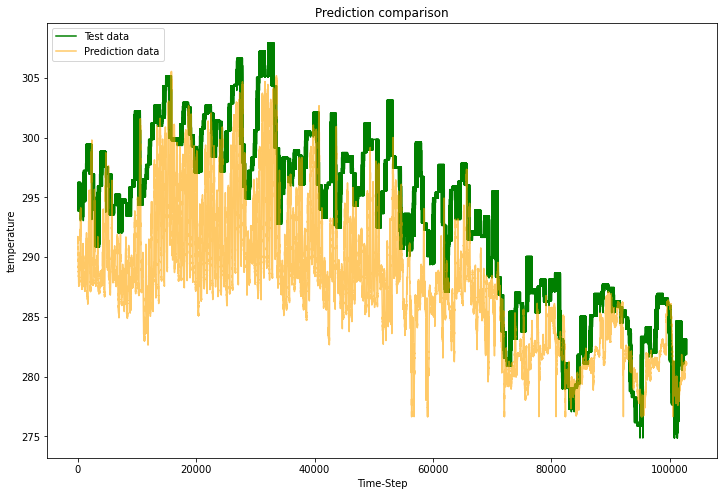

In [ ]:
plt.figure(figsize=(12,8))
plt.title('Prediction comparison')
plt.xlabel('Time-Step')
plt.ylabel('temperature')
plt.plot(np.arange(0,prediction_len),test_plt,color="green", label="Test data")
plt.plot(np.arange(0,prediction_len),prediction_plt,color="orange",label="Prediction data", alpha=0.6)
plt.legend(loc="upper left")
plt.show()

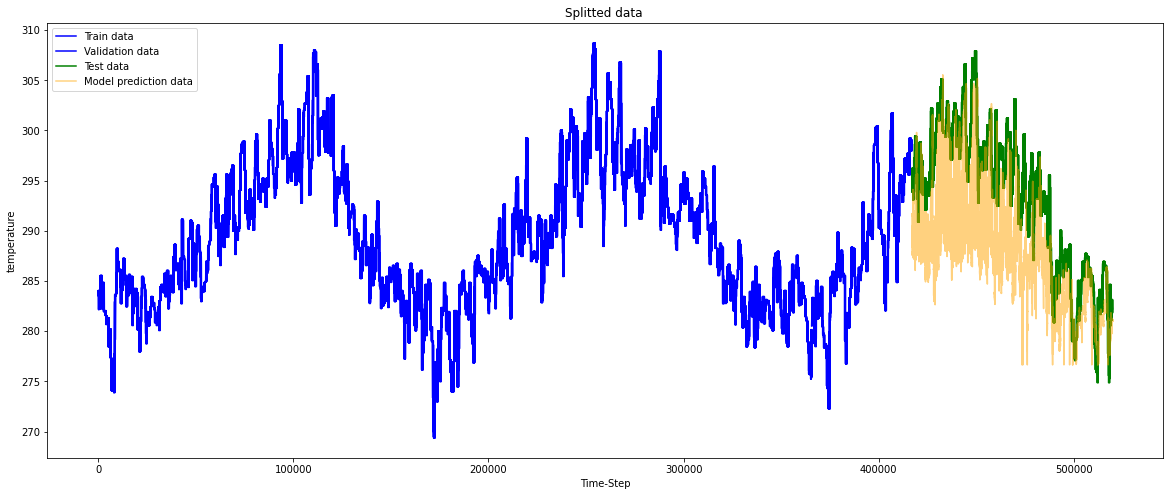

In [ ]:
plt.figure(figsize=(20,8))
plt.title('Splitted data ')
plt.xlabel('Time-Step')
plt.ylabel('temperature')
plt.plot(np.arange(0,train_len),train_plt, label="Train data", color="blue")
plt.plot(np.arange(train_len,val_len),val_plt, label="Validation data", color="blue")
plt.plot(np.arange(val_len,test_len),test_plt, label="Test data", color="green")
plt.plot(np.arange(val_len,test_len),prediction_plt, label="Model prediction data", color="orange", alpha=0.5)
plt.legend(loc="upper left")
plt.show()

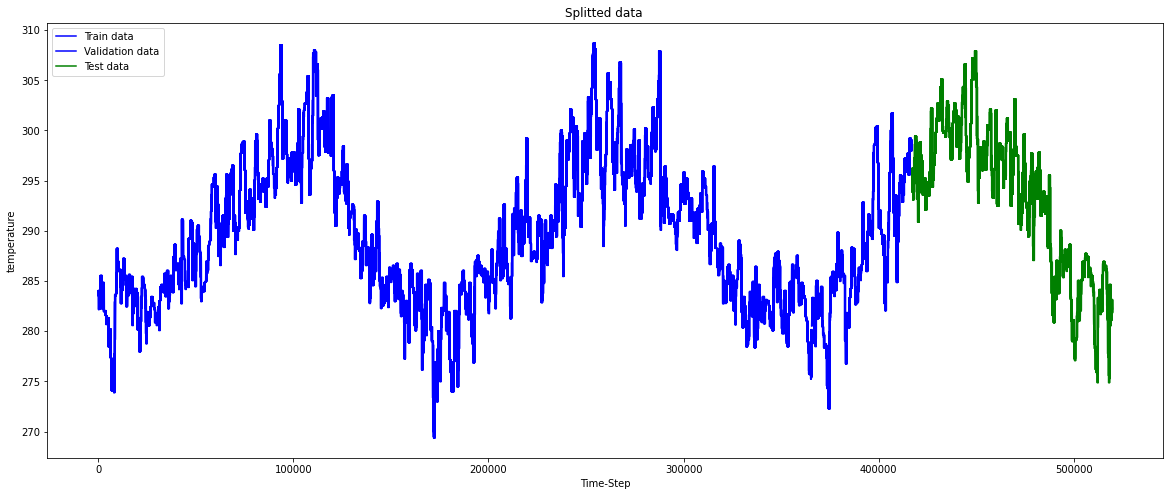

In [ ]:
plt.figure(figsize=(20,8))
plt.title('Splitted data ')
plt.xlabel('Time-Step')
plt.ylabel('temperature')
plt.plot(np.arange(0,train_len),train_plt, label="Train data", color="blue")
plt.plot(np.arange(train_len,val_len),val_plt, label="Validation data", color="blue")
plt.plot(np.arange(val_len,test_len),test_plt, label="Test data", color="green")
plt.legend(loc="upper left")
plt.show()

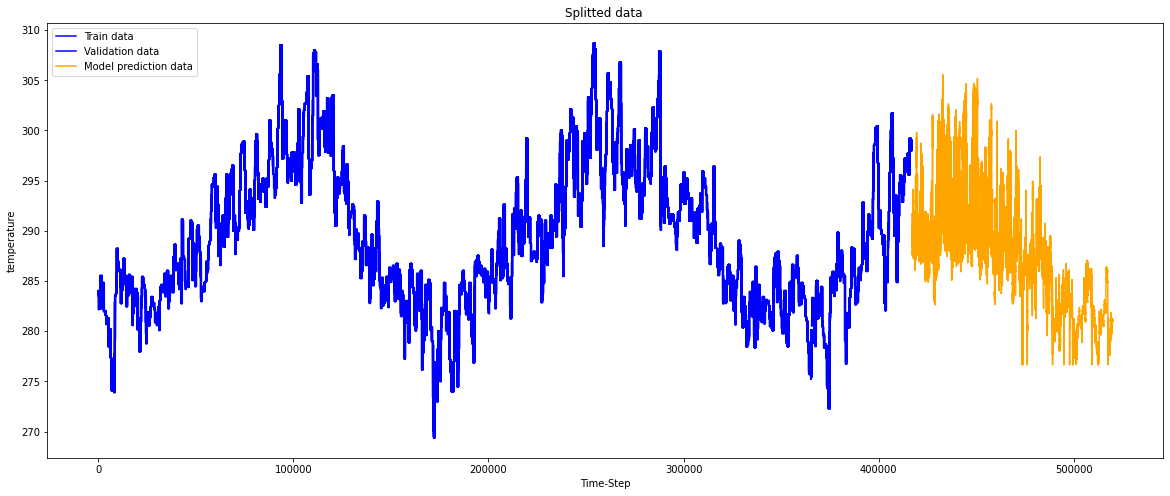

In [ ]:
plt.figure(figsize=(20,8))
plt.title('Splitted data ')
plt.xlabel('Time-Step')
plt.ylabel('temperature')
plt.plot(np.arange(0,train_len),train_plt, label="Train data", color="blue")
plt.plot(np.arange(train_len,val_len),val_plt, label="Validation data", color="blue")
plt.plot(np.arange(val_len,test_len),prediction_plt, label="Model prediction data", color="orange")
plt.legend(loc="upper left")
plt.show()